# 기본세팅

In [3]:
### 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab의 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/fonts/truetype
	/usr/share/fonts/truetype/dejavu
	/usr/share/fonts/truetype/liberation
	/usr/share/fonts/truetype/nanum
/root/.local/share/fonts: skipping, no such directory
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/root/.fonts: skipping, no such directory
/usr/shar

In [235]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [236]:
from wordcloud import WordCloud

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

In [99]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats
import pyLDAvis
import pyLDAvis.lda_model

# 간병인 플랫폼 어플 리뷰 분석
## 분석 목적 : 레어필드 간병인서비스와 유사한 사업을 운영하고 있는 경쟁업체 플랫폼의 어플 리뷰 분석
- 경쟁업체 분석을 통한 pain point 접근
- 환자용 어플과 간병인용 어플 분류하여 접근

### 분석 방향
1) 경쟁사 어플리케이션 리뷰 환자용/간병인용 분류
1) 경쟁사 어플리케이션 리뷰 긍/부정 분류
2) 긍정 리뷰 keyword 추출
3) 부정 리뷰 keyword 추출 (pain point)
4) 비교 차트 그리기 & 우리 사업의 방향성 제시

#### dataset 불러오기

In [6]:
# mongo에서 db 불러오는 함수
import pymongo
def dbconnect(collection) :
    client=pymongo.MongoClient('mongodb://trainings.iptime.org',45003)
    db= client['data_analysis']
    collection = db[collection]
    data = collection.find()
    df = pd.DataFrame(data)
    return df

In [7]:
# 중복값 제거하는 함수(contents를 기준으로)
def drop_duplicates(df, contents) : 
    df.drop_duplicates(subset=contents, keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [8]:
# 특정 열에서 list를 str으로 변환하는 함수
def list_join(row) :
    row = ' '.join(row)
    return row

In [9]:
# 특정 열에서 \n 삭제하는 함수
def remove_text(row):
    if pd.notnull(row):
        row = row.replace(r'\n', ' ')
    return row

In [10]:
# 구글 플레이스토어 리뷰 불러오기
df_googlestore = dbconnect('caregive_platform_google')
# 애플 앱스토어 리뷰 불러오기
df_applestore = dbconnect('caregive_platform_apple')
# 행으로 데이터프레임 합치기
df_medical_platform = pd.concat([df_googlestore, df_applestore], axis=0)
df_medical_platform

,_id,app_name,user_score,user_date,user_comments,evaluation
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,3
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",14
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,13
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,2
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,
...,...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,0
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,0
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,0
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,0


In [11]:
df_applestore['app_name'].value_counts()
# 제외할 겂 없음

app_name
케어닥       54
토닥씨       35
케어네이션     33
또하나의가족    30
병원잡       15
헬퍼         5
Name: count, dtype: int64

#### data 전처리

In [12]:
df_medical_platform.isnull().sum()

_id              0
app_name         0
user_score       0
user_date        0
user_comments    0
evaluation       0
dtype: int64

In [13]:
del df_medical_platform['evaluation']
df_medical_platform

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


#### 간병인용(지수) / 환자용(유경) 분리

In [14]:
df_medical_platform['app_name'].value_counts()

app_name
케어네이션                            1843
케어네이션(간병인용)                       928
좋은케어                              488
또하나의가족                            110
케어닥                               100
병원잡                                55
간병 나이팅게일                           42
토닥씨                                35
좋은 케어                              20
이웃하다                               17
케어파트너 요양보호사 장기요양 구직 취업 일자리 찾기      15
헬퍼                                 11
케어링크                               11
케어플러스                               9
헬로우케어                               6
캐어매치                                5
따뜻한돌봄                               4
Name: count, dtype: int64

In [15]:
# 환자용 
df_medical_platform_patient = df_medical_platform[df_medical_platform['app_name'].isin(['케어닥', '케어네이션', '헬퍼', '케어플러스', '이웃하다', '좋은 케어', '간병 나이팅게일', '또하나의가족', '헬로우케어', '토닥씨'])]
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


In [16]:
# 간병인용 
df_medical_platform_caremanager = df_medical_platform[df_medical_platform['app_name'].isin(['케어닥', '케어네이션(간병인용)', '헬퍼', '케어링크', '케어매치', '케어파트너 요양보호사 장기요양 구직 취업 일자리 찾기', '병원잡'])]
df_medical_platform_caremanager

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
137,664abf095d1ec9ef48becefc,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!
138,664abf095d1ec9ef48becefd,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...
139,664abf095d1ec9ef48becefe,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다
140,664abf095d1ec9ef48beceff,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요


#### 간병인용 전처리

In [40]:
df_medical_platform_caremanager.drop(columns='_id', inplace=True)

/tmp/ipykernel_1724/1921062872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_caremanager.drop(columns='_id', inplace=True)


In [41]:
df_medical_platform_caremanager

,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab
0,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 부팅 점 개선 좋 사용 불편 매칭 되
1,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 간 병비 싸 지역 나누 병원 재가 좋
2,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.,편리 실용
3,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음,입주 경력 많
4,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,정보 제공 감사
...,...,...,...,...,...,...
137,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉 없 공고 좋 같
138,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알 때 병원 잡 하나 면 한눈 알아보 일자리 있 좋 이런 플 있 알
139,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈 빠르 전국 병원 구인 있 좋 이력서 등록 편리
140,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요,공고 한눈 보 좋 편리


#### 환자용 경쟁사 어플리케이션 리뷰 분석

##### 1. 경쟁사 어플리케이션 리뷰 전체 분석

In [28]:
df_medical_platform_caremanager

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
137,664abf095d1ec9ef48becefc,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!
138,664abf095d1ec9ef48becefd,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...
139,664abf095d1ec9ef48becefe,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다
140,664abf095d1ec9ef48beceff,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요


###### 형태소 분석기

###### mecab

In [29]:
# 숫자 삭제
df_medical_platform_caremanager['review_preprocess'] = df_medical_platform_caremanager['user_comments'].str.replace('[0-9]','',regex=True)
df_medical_platform_caremanager

/tmp/ipykernel_1724/578885581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_caremanager['review_preprocess'] = df_medical_platform_caremanager['user_comments'].str.replace('[0-9]','',regex=True)


,_id,app_name,user_score,user_date,user_comments,review_preprocess
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...,...
137,664abf095d1ec9ef48becefc,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!
138,664abf095d1ec9ef48becefd,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...
139,664abf095d1ec9ef48becefe,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다
140,664abf095d1ec9ef48beceff,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요


In [45]:
df_medical_platform_caremanager['review_preprocess'].values[3]

'입주경력많음'

In [19]:
!pip install python-mecab-ko

In [31]:
from mecab import MeCab
mecab = MeCab()

In [54]:
mecab.pos(df_medical_platform_caremanager['review_preprocess'].values[16])

[('점점', 'MAG'),
 ('발전', 'NNG'),
 ('하', 'XSV'),
 ('는', 'ETM'),
 ('거', 'NNB'),
 ('같', 'VA'),
 ('습니다', 'EF'),
 ('케', 'IC'),
 ('어', 'IC'),
 ('네이션', 'NNP'),
 ('따라잡', 'VV'),
 ('는', 'ETM'),
 ('그날', 'NNG'),
 ('까지', 'JX'),
 ('파이팅', 'IC'),
 ('하', 'VV'),
 ('시', 'EP'),
 ('길', 'ETN+JKO'),
 ('~~', 'SY'),
 ('^^', 'SY')]

In [55]:
def mecab_tag(text):
    morphs_nouns = []
    morphs_nouns_list = []
    for sentence in text:
        # 명사, 형용사, 동사
        morphs = [morph for morph, tag in mecab.pos(sentence) if tag in ['VV+ETN', 'MM', 'NNG', 'NNP', 'NP', 'NR', 'VA', 'VV', 'VV+EC', 'SY', 'VA+ETM', 'XR']]
        morphs_nouns.append(' '.join(morphs))
    
    return morphs_nouns

In [56]:
df_medical_platform_caremanager.isnull().sum()

app_name              0
user_score            0
user_date             0
user_comments         0
review_preprocess     0
review_clean_mecab    0
dtype: int64

In [58]:
morphs_nouns = mecab_tag(df_medical_platform_caremanager['user_comments'])

In [59]:
df_medical_platform_caremanager['review_clean_mecab'] = morphs_nouns

/tmp/ipykernel_1724/461998890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_caremanager['review_clean_mecab'] = morphs_nouns


In [60]:
df_medical_platform_caremanager

,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab
0,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 돌아와서 부팅 점 개선 좋 사용 불편 매칭 되
1,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 ! 간 병비 싸 지역 나누 병원 재가 나눠서 보여 좋 ! 😠😠😠👊👊👊👊👊
2,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.,간단 편리 실용
3,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음,입주 경력 많
4,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보 제공 감사 ~^^~
...,...,...,...,...,...,...
137,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉 없 공고 올라와서 좋 같
138,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알 힘들 때 병원 잡 하나 면 한눈 알아보 일자리 있 좋 !! 이런 플 있 알
139,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈 빠르 전국 병원 구인 있 좋 이력서 등록 편리 합니다
140,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요,공고 한눈 보 좋 편리


In [70]:
df_medical_platform_caremanager.loc[df_medical_platform_caremanager['review_clean_mecab'] == "", 'review_clean_mecab'] =df_medical_platform_caremanager.loc[df_medical_platform_caremanager['review_clean_mecab'] == "", 'review_preprocess']

In [71]:
df_medical_platform_caremanager

,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab
0,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 돌아와서 부팅 점 개선 좋 사용 불편 매칭 되
1,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 ! 간 병비 싸 지역 나누 병원 재가 나눠서 보여 좋 ! 😠😠😠👊👊👊👊👊
2,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.,간단 편리 실용
3,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음,입주 경력 많
4,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보 제공 감사 ~^^~
...,...,...,...,...,...,...
137,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉 없 공고 올라와서 좋 같
138,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알 힘들 때 병원 잡 하나 면 한눈 알아보 일자리 있 좋 !! 이런 플 있 알
139,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈 빠르 전국 병원 구인 있 좋 이력서 등록 편리 합니다
140,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요,공고 한눈 보 좋 편리


###### okt

In [72]:
!pip install konlpy

In [73]:
from konlpy.tag import Okt
okt = Okt()

In [74]:
# 조사, 어미, 구두점 같은 것을 제거
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation', 'Adverb', 'Suffix', 'KoreanParticle', 'Alpha', 'Verb']:
            clean_text.append(word[0])

    return " ".join(clean_text)

In [75]:
df_medical_platform_caremanager['review_clean_okt'] = df_medical_platform_caremanager['review_preprocess'].apply(okt_clean)

/tmp/ipykernel_1724/1994689050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_caremanager['review_clean_okt'] = df_medical_platform_caremanager['review_preprocess'].apply(okt_clean)


In [76]:
df_medical_platform_caremanager['review_clean_okt']

0      오늘 갑자기 에러 자꾸 글구 보고 있다 창 유지 처음 재부팅 점 개선 좋다 사용 불...
1              업그레이드 맘 안듭니 간병 비도 지역별 병원 재 가도 좋다 😠😠😠👊👊👊👊👊
2                                        간단하다 편리하다 실용 이다
3                                               이다 경력 많다
4                                          알차다 정보 제공 참으로
                             ...                        
137                                   렉 없다 항상 공고 좋다 것 같다
138    이 곳 저 곳 알 보기 힘들다 때 병원 잡 어플 하나 \n 한눈 일자리 구 수 있다...
139                   한눈 빠르다 전국 병원 구인 있다 좋다 \n 이력서 등록 편리
140                                     공고 한눈 보기 좋다 편리하다
141    편리하다 사용 수 있다 좋다 광고 어플 보기 없다 무엇 채용 공 고가 자주 접속 대...
Name: review_clean_okt, Length: 1120, dtype: object

In [78]:
okt.pos(df_medical_platform_caremanager['review_clean_okt'].values[10])

[('케어', 'Noun'),
 ('닥', 'Noun'),
 ('일자리', 'Noun'),
 ('있다', 'Adjective'),
 ('같다', 'Adjective'),
 ('항상', 'Noun'),
 ('필요하다', 'Adjective'),
 ('사람', 'Noun'),
 ('도움', 'Noun'),
 ('좋다', 'Adjective'),
 ('일자리', 'Noun'),
 ('케어', 'Noun'),
 ('닥', 'Noun'),
 ('번창', 'Noun')]

In [147]:
# 문장 정리 및 재정제
def solve_text(text):
    change_dict = {
        '바 우 처': '바우처'
        , '고객 센터' : '고객센터'
        , '단 언 컨데' : '단언컨데'
        , '별 점' : '별점'
        , '성 공률' : '성공률'
        , '페북' : '페이스북'
        , '트립어드 바이 저' : '트립어드바이저'
        , '사용자 들' : '사용자들'
        , '사람 들' : '사람들'
        , '믿음 직' : '믿음직'
        , '동반 자' : '동반자'
        , '일반 적' : '일반적'
        , '직관 적' : '직관적'
        , '마이 리얼 트립' : '마이리얼트립'
        , '엑 티비 티' : '엑티비티'
        , '결재' : '결제'
        , '대 구' : '대구'
        , '자유 여 행' : '자유여행'
        , '할인 율' : '할인율'
        , '필수 픔' : '필수품'
        , '현 지' : '현지'
        , '예 매' : '예매'
        , '항공 료' : '항공료'
        , '여 행시' : '여행시'
        , '한 달동 안' : '한달동안'
        , '카카오 톡' : '카카오톡'
        , '쵝오' : '최고'
        , '낚시 성' : '낚시성'
        , '투 닥투닥' : '투닥투닥'
        , '필터 링' : '필터링'
        , '자체 적' : '자체적'
        , '동 일' : '동일'
        , '자다' : '잘'
        , '용하다' : '이용하다'
        , '어 울다' : '어울리다'
        , '예 약' : '예약'
        , '애러' : '에러'
    }
    for i in change_dict:
        text = text.replace(i,change_dict[i])
    return text

In [148]:
df_appreview

,_id,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab,review_clean_okt
0,662f0b3073f7ce16925e7c72,triple,5,2024년 4월 20일,"트리플 덕분에 최근에 다녀온 여행 계획을 편하게 짰습니다. 다만, 아쉬운 점이 있습...","트리플 덕분에 최근에 다녀온 여행 계획을 편하게 짰습니다. 다만, 아쉬운 점이 있습...",덕분 최근 여행 계획 편하 점 있 가계부 지출 항목 다양 좋 교통비 예 들 항공 ...,트리플 덕분 최근 여행 계획 편하다 다만 아쉽다 점 있다 가계부 지 출항 목 좀 더...
1,662f0b3073f7ce16925e7c73,triple,4,2024년 4월 2일,여행 일정 잡을 때. 가장 애용하고 손이 많이 가는 앱입니다 :) 너무너무 아쉬운 ...,여행 일정 잡을 때. 가장 애용하고 손이 많이 가는 앱입니다 :) 너무너무 아쉬운 ...,여행 일정 잡 때 애용 손 가 앱 점 버전 없 여행 일정 결국 마지막 각 잡 때 많...,여행 일정 잡 때 가장 애용 손 앱 이다 아쉽다 점 버전 없다 게 여행 일정 마지막...
2,662f0b3073f7ce16925e7c74,triple,5,2024년 3월 31일,"갤럭시 폴드하고 태블릿에서 더 좋은 사용성을 가진 UX가 제공되서 좋네요 다만, P...","갤럭시 폴드하고 태블릿에서 더 좋은 사용성을 가진 UX가 제공되서 좋네요 다만, P...",갤럭시 폴드 태블릿 좋 사용 제공 좋 버전 오프라인 모드 지원 없 같 계획 일정 때...,갤럭시 폴 드하 태블릿 더 좋다 사용성 제공 좋다 다만 버전 오프라인 모드 지원 주...
3,662f0b3073f7ce16925e7c75,triple,5,2024년 3월 3일,"진짜 편함. 특히 친구들이랑 같이 여행할 때 계획 짜고, 가계부 적어서 자동으로 1...","진짜 편함. 특히 친구들이랑 같이 여행할 때 계획 짜고, 가계부 적어서 자동으로 /...",친구 여행 때 계획 짜 가계부 적 자동 하 날씨 환율 확인 되 최고 하나 점 오프라...,진짜 편하다 친구 여행 때 계획 가계부 자동 날씨 환율 확인 바로 거 최고 하나 아...
4,662f0b3073f7ce16925e7c76,triple,5,2024년 3월 4일,같이 일정을 짜고 공유할 수 있다는 게 좋고 무엇보다 여기저기 영상 뒤지고 인스타 ...,같이 일정을 짜고 공유할 수 있다는 게 좋고 무엇보다 여기저기 영상 뒤지고 인스타 ...,일정 짜 공유 있 좋 무엇 여기저기 영상 뒤지 인 스타 피드 뒤지 하 대표 관광지 ...,일정 공유 수 있다 게 좋다 무엇 여기저기 영상 인스타 피드 대표 관광지 대표 스팟...
...,...,...,...,...,...,...,...,...
3896,6645de8483f867cdd7e8996a,대한민국 구석구석,5,2015년 9월 21일,ㅡ굿,ㅡ굿,,굿
3897,6645de8483f867cdd7e8996b,대한민국 구석구석,5,2015년 2월 25일,박서규,박서규,박 서규,박서 규
3898,6645de8583f867cdd7e8996c,대한민국 구석구석,5,2013년 6월 29일,최곡,최곡,곡,최곡
3899,6645de8583f867cdd7e8996d,대한민국 구석구석,5,2014년 12월 7일,영호,영호,영호,영호


In [149]:
df_appreview.query('review_clean_okt == ""')

,_id,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab,review_clean_okt
2001,662f183961d9aa4564c079ef,triple,5,2023년 1월 2일,아직까지는,아직까지는,,
2019,662f183a61d9aa4564c07a01,triple,5,2019년 7월 17일,good,good,,
2020,662f183a61d9aa4564c07a02,triple,5,2019년 7월 4일,good,good,,
2023,662f183a61d9aa4564c07a05,triple,5,2019년 4월 12일,good,good,,
2029,662f183a61d9aa4564c07a0b,triple,5,2022년 4월 21일,써보세요!!,써보세요!!,,
2034,662f183a61d9aa4564c07a10,triple,5,2019년 5월 6일,so good!!!,so good!!!,,
2035,662f183b61d9aa4564c07a11,triple,5,2021년 11월 1일,Perfect,Perfect,,
2379,662f3b6134754d6a96872776,triple,5,2021-11-15T01:54:57-07:00,ㅇ,ㅇ,,
2447,662f3b6234754d6a968727ba,triple,5,2020-10-26T20:19:31-07:00,very very,very very,,
2482,662f3b6234754d6a968727dd,triple,5,2020-07-28T07:07:11-07:00,.,.,,


In [79]:
# 어플명 제거
import re

pattern = '은'

df_medical_platform_caremanager['review_clean_mecab'] = df_medical_platform_caremanager['review_clean_mecab'].str.replace(pattern, '', regex=True)
df_medical_platform_caremanager['review_clean_okt'] = df_medical_platform_caremanager['review_clean_okt'].str.replace(pattern, '', regex=True)

/tmp/ipykernel_1724/3281838991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_caremanager['review_clean_mecab'] = df_medical_platform_caremanager['review_clean_mecab'].str.replace(pattern, '', regex=True)
/tmp/ipykernel_1724/3281838991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_caremanager['review_clean_okt'] = df_medical_platform_caremanager['review_clean_okt'].str.replace(pattern, '', regex=True)


In [81]:
df_medical_platform_caremanager

,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab,review_clean_okt
0,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 돌아와서 부팅 점 개선 좋 사용 불편 매칭 되,오늘 갑자기 에러 자꾸 글구 보고 있다 창 유지 처음 재부팅 점 개선 좋다 사용 불...
1,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 ! 간 병비 싸 지역 나누 병원 재가 나눠서 보여 좋 ! 😠😠😠👊👊👊👊👊,업그레이드 맘 안듭니 간병 비도 지역별 병원 재 가도 좋다 😠😠😠👊👊👊👊👊
2,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.,간단 편리 실용,간단하다 편리하다 실용 이다
3,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음,입주 경력 많,이다 경력 많다
4,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보 제공 감사 ~^^~,알차다 정보 제공 참으로
...,...,...,...,...,...,...,...
137,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉 없 공고 올라와서 좋 같,렉 없다 항상 공고 좋다 것 같다
138,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알 힘들 때 병원 잡 하나 면 한눈 알아보 일자리 있 좋 !! 이런 플 있 알,이 곳 저 곳 알 보기 힘들다 때 병원 잡 어플 하나 \n 한눈 일자리 구 수 있다...
139,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈 빠르 전국 병원 구인 있 좋 이력서 등록 편리 합니다,한눈 빠르다 전국 병원 구인 있다 좋다 \n 이력서 등록 편리
140,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요,공고 한눈 보 좋 편리,공고 한눈 보기 좋다 편리하다


###### okt로 선택

In [82]:
df_medical_platform_caremanager

,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab,review_clean_okt
0,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 돌아와서 부팅 점 개선 좋 사용 불편 매칭 되,오늘 갑자기 에러 자꾸 글구 보고 있다 창 유지 처음 재부팅 점 개선 좋다 사용 불...
1,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 ! 간 병비 싸 지역 나누 병원 재가 나눠서 보여 좋 ! 😠😠😠👊👊👊👊👊,업그레이드 맘 안듭니 간병 비도 지역별 병원 재 가도 좋다 😠😠😠👊👊👊👊👊
2,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.,간단 편리 실용,간단하다 편리하다 실용 이다
3,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음,입주 경력 많,이다 경력 많다
4,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보 제공 감사 ~^^~,알차다 정보 제공 참으로
...,...,...,...,...,...,...,...
137,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉 없 공고 올라와서 좋 같,렉 없다 항상 공고 좋다 것 같다
138,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알 힘들 때 병원 잡 하나 면 한눈 알아보 일자리 있 좋 !! 이런 플 있 알,이 곳 저 곳 알 보기 힘들다 때 병원 잡 어플 하나 \n 한눈 일자리 구 수 있다...
139,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈 빠르 전국 병원 구인 있 좋 이력서 등록 편리 합니다,한눈 빠르다 전국 병원 구인 있다 좋다 \n 이력서 등록 편리
140,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요,공고 한눈 보 좋 편리,공고 한눈 보기 좋다 편리하다


In [83]:
df_medical_platform_caremanager.isin(['']).sum()

app_name              0
user_score            0
user_date             0
user_comments         0
review_preprocess     0
review_clean_mecab    0
review_clean_okt      9
dtype: int64

In [282]:
df_medical_platform_caremanager.loc[df_medical_platform_caremanager['review_clean_okt']=="", 'review_clean_okt'] = df_medical_platform_caremanager.loc[df_medical_platform_caremanager['review_clean_okt']=="", 'review_clean_mecab']

In [283]:
df_medical_platform_caremanager_final = df_medical_platform_caremanager.copy()

In [284]:
df_medical_platform_caremanager_final.replace({'': np.nan}, inplace=True)

In [285]:
df_medical_platform_caremanager_final.dropna(subset=['review_clean_okt'], inplace=True)

In [286]:
df_medical_platform_caremanager_final.isin(['']).sum()

app_name              0
user_score            0
user_date             0
user_comments         0
review_preprocess     0
review_clean_mecab    0
review_clean_okt      0
dtype: int64

In [287]:
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final.reset_index()

In [288]:
# 어플명 제거
import re

pattern = '네이션|어플|없다|인|구|수|앱|있다|센터고객|간병|간병인|좋다|정말|덕분|케어|같다|서비스|감사|케어닥|케어네이션(간병인용)|헬퍼|케어링크|케어매치|케어파트너요양보호사장기요양구직취업일자리찾기|병원잡|케어플러스|이웃하다|좋은케어|간병나이팅게일|또하나의가족|헬로우케어|토닥씨'
df_medical_platform_caremanager_final['review_clean_mecab'] = df_medical_platform_caremanager_final['review_clean_mecab'].str.replace(pattern, '', regex=True)
df_medical_platform_caremanager_final['review_clean_okt'] = df_medical_platform_caremanager_final['review_clean_okt'].str.replace(pattern, '', regex=True)

In [290]:
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('젊은 사람은 칼대면 온몸에 암이 퍼져서 금방 죽는다는 개소리 시전으로 간병 시작함 ㅋㅋ')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('아빠가 갑자기 병원에 입원해서 급하게 간병인 찾다가 알게 되었는데요.')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('이상해요 구직활동에도움이안되네요 왜만들었는지모르겠어요 튕겨서화날려고하네요')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('몇달전부터 왜 자꾸 "비번변경 후 사용하세요"라는 문구가 뜨고')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('맞춤채용정보가 왜 안뜨는건가요?')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('여전히 안되네요')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('회원가입 하려고 하니까 생년월일이랑 성별 선택이 안되가지고 네이버로 가입해도 안되고 그냥 회원가입도 안되고 ㅠㅠ 수정 부탁드려요.. 제발..요')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('권한설정을 허용으로 해도 앱이 안열리고 그대로 권한설정하라고만 되어있어요 앱을 삭제하고 다시 깔아도 안드로이드 제부팅하고 다시깔아도 같은 현상')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('간편로그인 한 계정이 로그인 풀렸을 때 로그인 하려면 회원가입이 뜨고, 이미 인증된 번호라면서 새로 가입도 안되어서 계정이 그대로 날아감')]
df_medical_platform_caremanager_final = df_medical_platform_caremanager_final[~df_medical_platform_caremanager_final['user_comments'].str.contains('이상해요 구직활동에도움이안되네요 왜만들었는지모르겠어요 튕겨서화날려고하네요')]

##### 토픽 추출

In [291]:
df_medical_platform_caremanager_final

,index,app_name,user_score,user_date,user_comments,review_preprocess,review_clean_mecab,review_clean_okt
0,0,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 돌아와서 부팅 점 개선 좋 사용 불편 매칭 되,오늘 갑자기 에러 자꾸 글 보고 창 유지 처음 재부팅 점 개선 사용 불편하다 매...
1,1,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...","업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 ! 간 병비 싸 지역 나누 병원 재가 나눠서 보여 좋 ! 😠😠😠👊👊👊👊👊,업그레이드 맘 안듭니 비도 지역별 병원 재 가도 😠😠😠👊👊👊👊👊
2,2,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,간단하고 편리하며 실용적 입니다.,간단 편리 실용,간단하다 편리하다 실용 이다
3,3,케어닥,5,2024년 4월 1일,입주경력많음,입주경력많음,입주 경력 많,이다 경력 많다
4,4,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,알찬 정보 제공 ~^^~,알차다 정보 제공 참으로
...,...,...,...,...,...,...,...,...
1115,137,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!,렉 없 공고 올라와서 좋 같,렉 항상 공고 것
1116,138,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...,이곳저곳 알 힘들 때 병원 잡 하나 면 한눈 알아보 일자리 있 좋 !! 이런 플 있 알,이 곳 저 곳 알 보기 힘들다 때 병원 잡 하나 \n 한눈 일자리 이렇다 ...
1117,139,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다,한눈 빠르 전국 병원 있 좋 이력서 등록 편리 합니다,한눈 빠르다 전국 병원 \n 이력서 등록 편리
1118,140,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요,공고 한눈에 보기 좋아서 편리해요,공고 한눈 보 좋 편리,공고 한눈 보기 편리하다


In [292]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [293]:
# 텍스트 데이터 전처리 및 벡터화
vectorizer = TfidfVectorizer()
feature_12 = vectorizer.fit_transform(df_medical_platform_caremanager_final['review_clean_okt'])

# LDA 모델 훈련
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(feature_12)

vis = pyLDAvis.lda_model.prepare(lda, feature_12, vectorizer) # 토픽모델, 교육이 끝난 값(행렬형태), 교육모델

pyLDAvis.enable_notebook()
pyLDAvis.display(vis) # PCA - 차원축소

In [294]:
# 훈련된 LDA 모델로 문서별 토픽 할당
document_topics = lda.transform(feature_12)

# 각 문서의 주요 토픽 확인
for idx, topic in enumerate(document_topics):
    print(f"Document {idx} belongs to Topic {topic.argmax()}")

Document 0 belongs to Topic 1
Document 1 belongs to Topic 0
Document 2 belongs to Topic 0
Document 3 belongs to Topic 0
Document 4 belongs to Topic 2
Document 5 belongs to Topic 0
Document 6 belongs to Topic 1
Document 7 belongs to Topic 2
Document 8 belongs to Topic 1
Document 9 belongs to Topic 1
Document 10 belongs to Topic 2
Document 11 belongs to Topic 0
Document 12 belongs to Topic 1
Document 13 belongs to Topic 2
Document 14 belongs to Topic 2
Document 15 belongs to Topic 1
Document 16 belongs to Topic 1
Document 17 belongs to Topic 1
Document 18 belongs to Topic 1
Document 19 belongs to Topic 1
Document 20 belongs to Topic 0
Document 21 belongs to Topic 0
Document 22 belongs to Topic 1
Document 23 belongs to Topic 0
Document 24 belongs to Topic 2
Document 25 belongs to Topic 0
Document 26 belongs to Topic 0
Document 27 belongs to Topic 0
Document 28 belongs to Topic 1
Document 29 belongs to Topic 2
Document 30 belongs to Topic 2
Document 31 belongs to Topic 0
Document 32 belong

In [295]:
# 토픽 모델링 결과 해석
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    # 토픽별로 상위 단어 10개 출력
    top_word_indices = topic.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_word_indices if i < len(feature_names)]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: 추천, 환자, 이다, 사용, 선택, 여기, 정보, 만족하다, 일자리, 직접
Topic 1: 많다, 일자리, 편하다, 이용, 일감, 처음, 어렵다, 편리하다, 매칭, 협회
Topic 2: 도움, 후기, 필요하다, 보호자, 시작, 처음, 이벤트, 편하다, 아주, 찾기


#### 2. 긍/부정 point 극대화/개선 방안

##### 1) 긍부정 나누기

In [296]:
df_medical_platform_caremanager_final['user_score'] = df_medical_platform_caremanager_final['user_score'].astype(int)

In [297]:
df_medical_platform_caremanager_final['user_score']

0       3
1       1
2       5
3       5
4       5
       ..
1115    3
1116    5
1117    5
1118    4
1119    5
Name: user_score, Length: 1112, dtype: int64

In [298]:
df_positive = df_medical_platform_caremanager_final[(df_medical_platform_caremanager_final['user_score'] == 4) | (df_medical_platform_caremanager_final['user_score'] == 5)]
df_negative = df_medical_platform_caremanager_final[(df_medical_platform_caremanager_final['user_score'] == 1) | (df_medical_platform_caremanager_final['user_score'] == 2)]


##### 2) 긍정내용 토픽

In [299]:
# 텍스트 데이터 전처리 및 벡터화
vectorizer = TfidfVectorizer()
feature_positive = vectorizer.fit_transform(df_positive['review_clean_okt'])

# LDA 모델 훈련
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(feature_positive)

vis = pyLDAvis.lda_model.prepare(lda, feature_positive, vectorizer) # 토픽모델, 교육이 끝난 값(행렬형태), 교육모델

pyLDAvis.enable_notebook()
pyLDAvis.display(vis) # PCA - 차원축소

In [300]:
## 상위 단어 추출
## 0 확률 1은 dictionary
feature_names = vectorizer.get_feature_names_out()
topics_list = list()
for topic in lda.components_:
    df_datas = [topic, feature_names]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:20])# 시리즈 형식으로 출력 get values from series / index
    print(topics_text)
    topics_list.append(topics_text)


topics_list_add = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
df_topics_keywords = pd.DataFrame(topics_list_add)

일자리 편하다 많다 이다 이용 일감 매칭 처음 여기 제일 괜찮다 소개 이벤트 한번 이제 생각 어떻다 매일 추천 여러
도움 많다 환자 친절하다 원하다 편리하다 공고 편하다 유용하다 센터 일이 고맙다 고객 만족하다 일도 상태 보호자 지방 정보 미리
사용 협회 편하다 어렵다 추천 후기 시작 직접 필요하다 선택 바로 통장 아주 정보 만족스럽다 이렇다 사람 보고 입금 장점


In [301]:
topics_output = lda.transform(feature_positive)
df_topics_score = pd.DataFrame(data=topics_output)

In [302]:
import numpy as np
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1)
df_positive['topic'] =df_topics_score['dominant_topic_number']
df_positive[['topic','review_clean_okt']].groupby('topic').count()

/tmp/ipykernel_1724/4119953208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['topic'] =df_topics_score['dominant_topic_number']


,review_clean_okt
topic,
0.0,291
1.0,223
2.0,262


###### 긍정 review wordcloud


In [303]:
positive = ' '.join(df_positive['review_clean_okt'])

In [304]:
list_positive = positive.split()

In [305]:
from collections import Counter
text_split_count = Counter(list_positive)

In [306]:
wordCloud = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordCloud.generate_from_frequencies(text_split_count)

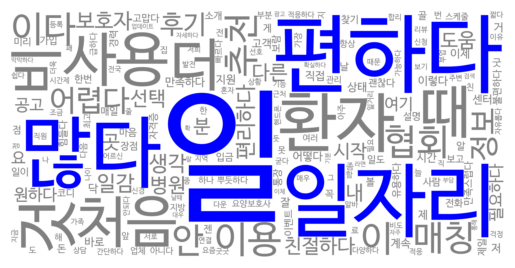

In [307]:
highlighted_words = ["편하다", "일자리", '일', '많다']
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in highlighted_words:
        return "blue"  # 특정 단어 색상
    else:
        return "gray"   # 나머지 단어 색상

wordCloud = WordCloud(scale=10, color_func=custom_color_func, background_color="white",font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate_from_frequencies(text_split_count)
# wordCloud.words
# wordCloud.generate_from_frequencies()

plt.imshow(wordCloud)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

###### 긍정 review 
주목할 keyword : 편하다, 일감, 유용하다, 센터, 많다, 일자리

In [308]:
def keyword_contents_positive(text):
    total_lists = df_positive['user_comments']
    filter = []
    for total_list in total_lists:
        try:
            if text in total_list:
                total_list = str(total_list)
                print(total_list)
                print("--------")
            else : 
                pass
        except:
            print(total_list)
            pass

In [309]:
keyword_contents_positive('일자리')

케어닥에서 내게 맞는 일자리를 찾을수 있을것같습니다 항상 필요하는 사람들에게 도움이 되는 좋은 일자리라고 봅니다 케어닥 감사하고 번창하시기 바랍니다
--------
일자리 찿고 있습니다 일자리 찾아 주세요 감사합니다.
--------
방문요양사 일자리구함니다가뭔도춘천입니다
--------
일자리 찾던차 아는 지인분 소개로 앱 사용하고나서 요즘 근근히 일 찾아 다니고있습니다.
--------
요즘에는 어플로 일자리 구한다길래^^ 해봤습니다 처음에는 안구해져 속상했지만 한번하고나니 쭉 쭉되네요^^
--------
알림으로 일자리 바로바로 알려주고 지원도 바로 해서 편하네요ㅎㅎㅎ
--------
일년전부터 썼었는데 일자리도 많아지고 대우도 더욱좋아진게 느껴지네요
--------
간병정보도 많고 일자리도 많아서 잘 사용하고 있어요
--------
짧게짧게 근무할 수 있는 일자리가 필요했는데 종종 잘 이용하고 있습니다^^
--------
지방인데 일자리도 많이 늘고 있어서 골라가기 좋네요 보호자도 친절합니다
--------
선호하는 일자리만 선택할 수 있으니깐 괜찮네요~
--------
간병일자리 구하는 앱 중에 일자리는 가장 많은듯.
--------
딸집에 놀러갔다가 근처에서 이틀 간병알바도 하고 왔어요~ 타지역에서도 이렇게 쉽게 일자리를 찾을수 있다니 놀랍네요
--------
일자리 많이 연결시켜주시니 고마워요 수수료도 적어요
--------
티비에서 광고보고 다운받았어요 일자리 올라오면 알려줘서 좋네요
--------
협회에 가입하는것보다 좋으네요~ 편하게 일자리 구할수있어 좋습니다
--------
일자리 선택하는게 참 좋네요 환자도 선택할수있고?
--------
스스로 일자리를 찾을 수 있어서 만족하면서 사용하는 중입니다
--------
적정한 일자리를 쉽게 찾을 수 있어 좋으네요
--------
일자리도 많고 간병하기 편한 곳입니다 추천해요
--------
일자리가 이렇게 많다니 너무 좋아요 다른 앱도 써봤는데 일자리 없어요... 여기가 제일 많고 다양해요~


In [310]:
keyword_contents_positive('일감')

일감을 쉽게 찾을수 있고 다른 간병인 앱보다 편한거같아요
--------
간병에만 전념할수있게 다른것은 신경쓰지 않아도 되고 일감 매칭도 잘되고 자유롭게 일 할수있어서 넘~ 좋습니다 ^^
--------
간호조무사로 일하다가 너무 힘들어서 관두고 이 앱을 알게 되어 시작하게 되었어요 일정관리도 편하고 일감도 많아 잘 쓰고 있네요
--------
간병인들은 하나씩 다 깔아두면 좋지 않을까요~ 일감찾는데 돈 들어가는 것도 아닌데^^ 전 추천하고 다닙니다^^
--------
생각날 때마다 들어와서 일감 찾기 좋습니다^^ 서비스 잘 유지해주십쇼~
--------
집에서 가까운 간병 일감을 보여주는 서비스가 개발되며 더욱 좋겠어요
--------
다른 것보다 간병인들이 일감을 직접 찾을 수 있다는 게 최고 장점인 것 같습니다!!
--------
지방으로 이사가게 되었는데 전국 서비스라 지방에도 공고가 있네요~ 덕분에 일감 찾는 걱정은 덜었네요~
--------
일감이 많아서 매칭이 잘되요 간병비도 빨리 들어와요
--------
매일 어떤 일감이 올라오나 계속 보게 되네요ㅎㅎ
--------
편하게 간병 일감을 구할 수 있어서 너무 좋아요
--------
보험료와 수수료를 한꺼번에 뜯어가는 업체에 비해 케어네이션은 일한날만 수수료가 부과되어서 협회일감이랑 같이 병행해도 좋겠네요ㅎㅎ
--------
이런 어플을 기다렸습니다~ 언제까지 불편하게 일감 받아야 하나 했어요~~만들어주셔서 감사해요~~
--------
간병인협회에서 일감을 기다리다가 직접 찾을 수 있다는 광고 보고 시작했는데 성취감을 오랜만에 느낄 수 있어서 좋네요
--------
생각보다 일감이 많아서 계속 일할 수 있어요 다음 달에는 더 많이 하려고요
--------
일감이 정말 많아요 골라서 할 수 있어서 좋아요
--------
매달 간병일감이 늘어나고 골라서 일을할수있으니 간병인한테는 참 편해요
--------
일감 찾기 편합니다 저는 저기 강남쪽만 보는데 좋아요
--------
집근처 일감찾을때 쓰니까 좋

In [311]:
keyword_contents_positive('유용')

꼭 필요한 앱이라서 넘 조아요 가족중에 병원에 입원하면 정말 난감한데ㅡ 유용하게 사용하겠습니다
--------
유용합니다
--------
간병하고 나면 내역이 다 남아서 유용해요
--------
심심할 때 간병케어백과로 공부합니다 유용해요
--------
간병인들을 위한 유용한 콘텐츠도 기대하겠습니다 ^ㅡ^
--------
커뮤니티에서 건강정보 유용해요 읽는 재미가 있네요
--------
요즘 많이 쓰는거 같은데.. 유용해요
--------
유용합니다 참~~
--------
유용할것같아요
--------
넘 유용해요
--------
일거리 찾고 할때 유용하게 쓰입니다.
--------
지인의 소개로 다운받았는데 일자리가 생각보다 많은것이 참 유용하네요.
--------


###### Wordcloud

In [312]:
keyword_contents_positive('매칭')

간병 일거리 지원하기에 앞서 프로필 입력하면 매칭율이 올라갑니다, 굿
--------
직접 공고 보고 매칭 원하는 환자분을 고를 수 있어서 좋습니다.
--------
간병에만 전념할수있게 다른것은 신경쓰지 않아도 되고 일감 매칭도 잘되고 자유롭게 일 할수있어서 넘~ 좋습니다 ^^
--------
환자 상태를 볼 수 있는게 좋긴 하더라고요.. 매칭 안되면... 애매하긴 한데.. 그래도 편하긴 편하네요.. 앱이라서 ㅎ
--------
매칭이 되기 위해서 후기와 경력을 쌓을 필요를 느낍니다..더 나은 간병인이 될 수 있도록 자극하는 시스템인 것 같아요..좋네요
--------
다 좋은데 매칭되면 보호자랑 대화를 할 수 있게 기능을 개발해주셨으면 좋겠어요...
--------
보호자가 선택하는거라 복불복이지만 그래도 여러군데 많이지원하니 잘 매칭이되네요
--------
경력을 인정받을 수 있는 곳인 것 같네요~ 물론 너무 높은 가격을 부르면 매칭이 안 되겠죠~^^
--------
간병일하는 지인이 추천해줬는데 아직 매칭은 안되었어요 빨리 일해보고 싶어요
--------
처음 매칭되서 일을 하게 됐는데 그분이 저한테 좋은 후기를 써주셔서 저도 이렇게 후기를 쓰게 됐습니다. 서로한테 감사한 마음 따뜻한 후기로 남겨줘서 좋은 추억도 되고 기분이 좋네요.
--------
처음에는 어려웠는데 한번 매칭되니까 좋네요 만족하면서 쓰고 있어요
--------
처음엔 매칭이 어려웠는데 한번 성공하니 조금씩 나아지네요 뿌듯합니다
--------
일감이 많아서 매칭이 잘되요 간병비도 빨리 들어와요
--------
빡...센 노동 강도에 터무니없이 낮은 가격을 원하는 보호자들이 있는데 여기서는 제가 간병비를 제안할 수 있으니 좋습니다 다만 매칭되느냐의문제일뿐..
--------
꾸준하게 하니까 후기도 쌓이고 매칭도 잘되니까 좋네요
--------
말이 필요없는 최고의 간병인 매칭 어플리케이션입니다.
--------
아직 적응하는 과정 중입니다~ 매칭은 잘 되는 것 같네요~
--------

##### 3) 부정내용 토픽

In [347]:
df_negative = df_negative.reset_index().drop(columns='index')

In [348]:
# 텍스트 데이터 전처리 및 벡터화
vectorizer = TfidfVectorizer()
feature_negative = vectorizer.fit_transform(df_negative['review_clean_okt'])

# LDA 모델 훈련
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(feature_negative)

vis = pyLDAvis.lda_model.prepare(lda, feature_negative, vectorizer) # 토픽모델, 교육이 끝난 값(행렬형태), 교육모델

pyLDAvis.enable_notebook()
pyLDAvis.display(vis) # PCA - 차원축소

In [349]:
# 토픽 모델링 결과 해석
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    # 토픽별로 상위 단어 10개 출력
    top_word_indices = topic.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_word_indices if i < len(feature_names)]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: 별로, 많다, 안되다, 일자리, 오류, 그렇다, 지방, 어떻다, 다른, 환자
Topic 1: 매칭, 일감, 탈퇴, 많다, 홍보, 자꾸, 경력, 제주도, 선택, 병원
Topic 2: 사람, 이체, 사용, 보호자, 안되다, 다음, 화면, 회사, 찾기, 최악


In [350]:
topics_output = lda.transform(feature_negative)
df_topics_score = pd.DataFrame(data=topics_output)

In [351]:
import numpy as np
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1)
df_negative['topic'] =df_topics_score['dominant_topic_number']
df_negative[['topic','review_clean_okt']].groupby('topic').count()

,review_clean_okt
topic,
0,30
1,40
2,34


###### 부정 review wordcloud


In [352]:
negative = ' '.join(df_negative['review_clean_okt'])

In [353]:
list_negative = negative.split()

In [354]:
from collections import Counter
text_split_count = Counter(list_negative)

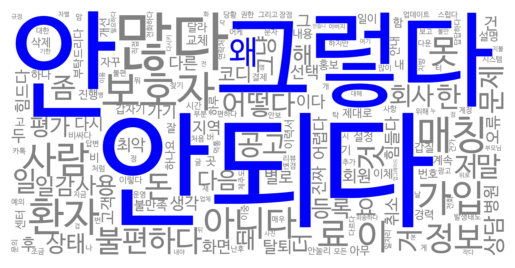

In [355]:
highlighted_words = ["안되다", "안", '왜', '그렇다']
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in highlighted_words:
        return "blue"  # 특정 단어 색상
    else:
        return "gray"   # 나머지 단어 색상

wordCloud = WordCloud(scale=10, color_func=custom_color_func, background_color="white",font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate_from_frequencies(text_split_count)
# wordCloud.words
# wordCloud.generate_from_frequencies()

plt.imshow(wordCloud)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

###### 부정 review 
- 주목할 keyword : 매칭, 안되다, 홍보, 없다, 먹통

In [356]:
def keyword_contents_negative(text):
    total_lists = df_negative['user_comments']
    filter = []
    for total_list in total_lists:
        try:
            if text in total_list:
                total_list = str(total_list)
                print(total_list)
                print("--------")
            else : 
                pass
        except:
            print(total_list)
            pass

In [357]:
keyword_contents_negative('매칭')

넘 매칭이안되요모든정보다주었는데그래서짜증나서삭제했어요
--------
매칭이 전혀 없네요 아쉽네요
--------
경력이 많이 없어서그런지 매칭되는게 엄청 잘되진 않네요
--------
환자를 선택할 수 있으니 좋네요 무조건 매칭은 아니지만...
--------
첨에 매칭이 안되서 실망했는데 어제 처음으로 됐네요!! 열심히 일해보겠습니다...
--------
편하고 매칭이 잘됩니다
--------
매칭이 잘 안 되어요~
--------
일주일 전에 예약하고 매칭완료 되었는데
병원 가기 하루 전날 그것도 오후6시반에
안된다는 통보가 와서 사람도 못구함
매칭해도 취소 당하는게 다분함
--------
제대로된 간병인을 등록시키고 최소한의 기한을 지키고 기준을 정해서 매칭을 해줘야 하는거 아닙니까. 가족이 아파 힘든 보호자가 간병인 구하는게 너무 어려워서 여기를 통해 구했는데, 아무도 책임지지않는 방식으로 그렇게 운영하니까 감병인들이 환자가 조금 힘들면 핑계대고 가버리죠. 그럼 안그래도 힘든 보호자가 또 그 상황을 책임져야하고 고통만 주는 이 앱 정말 최악이라고 생각하네요.
--------


In [358]:
keyword_contents_negative('일감')

지금 계속 앱에서 일이 있는 게 보이는데 그 지역에 어느 곳에서 일할 수 있는지 보려고 들어가면 일감이 없다고 뜨네요 그래서 삭제 했다 다시 깔고를 몇번씩 했는지 모르겠어요...
--------
일감 찾기 들어왔는데 ...... 없어요. 항목이요.
--------
일감이 많아 좋은건 맞는데 그렇게 말하지마세요
--------
서울에만 너무 일감이 몰려 있음
--------
제주도 일감은 없나요???
--------


In [359]:
keyword_contents_negative('별로')

업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠서 보여줬음 좋겠네요!!😠😠😠👊👊👊👊👊
--------
별로^^
--------
강원도는 공고가 많이 올라오나요?별로업는데
--------
지방인데 일자리가 별로 없네요
--------
제 동네에는 공고 아직 별로 없어요.....
--------


In [360]:
keyword_contents_negative('상담')

어플 가입하고 갑자기 계정 없어짐 재가입후 카톡 상담문의함 번호,이름 물어보더니 지들 조건이랑 안맞아서 그랬다함 ㅋㅋ 뭐가 안맞는지 말도 안하고 계정 삭제 시켜버리고 상담하는태도가 ㅋㅋ 지들 할말하고 감사합니다 ㅋ
--------
앱 사용하는 법을 몰라서 상담하시는 분한테 많이 물어봤는데...
--------
카톡가입으로 정보변경(연락처변경)도 안보이고, 탈퇴도안보이고 상담은 답변없고 불편해요 (보신다며 위에 문의답변주세요)
--------
아파트 광고 마시고, 앱 테스터를 더 두시던 잘 안되는 것 좀 개선하시길. 특히 상담원 채팅UX가 왕짜증, 하던 고객상담하던  대화를 찾아가기가 왜 이리 힘든지..그리고 케어코디 평가를 안하고 싶은데 평가를 안하면 7일 후에 자동을 별점 5점을 준다니.. 코디가 맘에 안들지만 잘 모르니 평가를 안할 수있는거지, 플랫폼에서 유리한정보를 양산허기 위해 이런 말도 안되는 정책을 끄는건지… 개선해야할부분이 산더미같네요
--------


In [361]:
keyword_contents_negative('왜')

어플다운받아서 권한설정했는데도 그 다음으로 진행도 않되고 터치도 않되고 이거 왜 그런거죠??
--------
입금 왜 일한날말고 다음날주죠?일한날주면좋을텐데...ㅠㅠ
--------
닫혀있는 앱을 왜 만들고 왜 광고 ㆍ홍보하는가 ?
--------
모든귄한 설정후에도 왜 열리지않나요?
--------
아파트 광고 마시고, 앱 테스터를 더 두시던 잘 안되는 것 좀 개선하시길. 특히 상담원 채팅UX가 왕짜증, 하던 고객상담하던  대화를 찾아가기가 왜 이리 힘든지..그리고 케어코디 평가를 안하고 싶은데 평가를 안하면 7일 후에 자동을 별점 5점을 준다니.. 코디가 맘에 안들지만 잘 모르니 평가를 안할 수있는거지, 플랫폼에서 유리한정보를 양산허기 위해 이런 말도 안되는 정책을 끄는건지… 개선해야할부분이 산더미같네요
--------
한번 여기 써본사람들은 안쓰지. 최근 댓글만봐도 너무티나 아무리 간병인이 케바케라고 해도 그렇치.그럼 다른업체랑 다를게뭐냐고.근데 왜비싸게받냐고 차별화된 서비스를하던가.질도 가격도 최악.비싸게돈받아서 홍보에다투자하나.결국보호자등골빼먹는회사
--------


In [362]:
keyword_contents_negative('안되')

넘 매칭이안되요모든정보다주었는데그래서짜증나서삭제했어요
--------
앱이 어려워서 고객센터에 물어봤는데 그래도 이해가 안되네요 어렵게 설명해요
--------
첨에 매칭이 안되서 실망했는데 어제 처음으로 됐네요!! 열심히 일해보겠습니다...
--------
다른 어플도 많이 써봤는데 불편함도 많고 지방은 안되는데
--------
터무니 없이 제시되는 간병비와 말도 안되게 떼어가는 수수료는 진정 어이가 없다는..
--------
회원가입 하려고 하니까 생년월일이랑 성별 선택이 안되가지고 네이버로 가입해도 안되고 그냥 회원가입도 안되고 ㅠㅠ 수정 부탁드려요.. 제발..
--------
아파트 광고 마시고, 앱 테스터를 더 두시던 잘 안되는 것 좀 개선하시길. 특히 상담원 채팅UX가 왕짜증, 하던 고객상담하던  대화를 찾아가기가 왜 이리 힘든지..그리고 케어코디 평가를 안하고 싶은데 평가를 안하면 7일 후에 자동을 별점 5점을 준다니.. 코디가 맘에 안들지만 잘 모르니 평가를 안할 수있는거지, 플랫폼에서 유리한정보를 양산허기 위해 이런 말도 안되는 정책을 끄는건지… 개선해야할부분이 산더미같네요
--------
간병인이 급하게 필요할 때 정말 유용한 건 맞는 데 좋은 간병인을 만나는냐는 또 다른 문제네요. 간병인의 서비스 불만족으로 간병인 교체를 요구하니 두명의 간병인비를 내야 해서 서비스 불만이라도 그냥 써야 하는 시스템은 좀 문제가 있다고 생각됩니다. 마치 내용에는 서비스 불만시 바로 간병인 교체해줄 것처럼 써있지만 실제론 안되는 아니면 돈을 두배로 지불해야합니다.
--------
웹사이트에서도 안되고 앱에서도 안되네요,, 자기소개까지 다 입력하고 다음을 누르면 도통 넘어가질 않습니다. 이력서를 등록해야 구직도 할텐데요ㅠㅠ
--------


In [363]:
keyword_contents_negative('안돼')

In [345]:
def keyword_contents_negative(text):
    total_lists = df_appreview.query('user_score == 1 or user_score == 2')['user_comments']
    filter = []
    for total_list in total_lists:
        try:
            if text in total_list:
                total_list = str(total_list)
                print(total_list)
                print("--------")
            else : 
                pass
        except:
            print(total_list)
            pass

In [275]:
keyword_contents_negative('위치')

괜히 설치했네. 위치 찍으면 주변 숙소정보를 알려주는 구글 보다 좋은점 일도 없음.
--------
지도에서 위치 고를때 추천해주는 장소에는 선택을 아예 못하게 되어있음 가지말라는건지 뭔...
--------
안녕하세요 트위터 광고보고 끌려서 왔네요 리뷰가 아직 미비로 보이는데...개인적 필기타블릿 필기폰을 활용하는 입장에서 길치와 방향치로써 지도도 보고 일정도 보면서 앱만 잘 만들면 괜찮은 앱 하나가 추가되겠네요^^ 추가 로그,위치카메라좌표찍기,위치메모좌표 이런것도 전 유용하던데요...
--------
스케줄 짜기엔 좋은 어플인데\n구글에서 찾은 가고 싶은 장소가 트리플에 맛집으로 등록이 안되어 있으면 스케줄에 장소를 추가 하지 못해서 불편함\n위치 검색되도록 등록하려면 신청해서 답변기다려야된다는대..\n언제 그짓거리를하라는 건지
--------
최악. 위치허용 켜도 계속 꺼지고 허용하라는 알림뜨고. 지역별 가볼만한곳은 도대체 전체 보기 기능은 왜없는지? 세금만 축내는 집단.
--------
다좋은데요~ 내위치 누르면 주위관광지 가 뜬다면 더없이 좋을것같아요 이기능이 없는 어플을 사용하다가 이기능이 있는 어플이 생긴다면 여기어플 회원상당수가 흡수될것같아요~ 타지역에 놀러갓는데 그지역의 관광지만 뜬다면 지도에서 일일이 검색해야하는 번거로움을 없앨수잇죠 이기능없는 어플기준으로 가려내는 사람들도 상당할만큼 이차이가크다고 생각들어요~~
--------
어플깔고 위치 허용 눌렀는데 할인 바코드찍어도 어플설치하라는 오류메시지만 뜸 나만 할인못받음 개짜증 직원이 했는데도 왜이러는지 모르겠다고함 제대로 만들지도 않을거면 이딴거하지마쇼
--------
위치 안맞구. 정보가 너무 없어요. 노력좀하이소
--------
위치를 켜도 내위치를 못찾는 앱
--------
위치검색 기능은 뭐하러 넣어놨나요? 안되는걸
--------
내 위치 찾기를 하면, 하세월이네요! 찾아주긴 하나요?
--------
위치정보 끄고 어플 좀 쓸 수 있게 해 주세요.
--------
참 좋은 앱인데 말

In [276]:
keyword_contents_negative('검색')

인터렉션만 화려하지 실상 일정을 짜려고 하면 지원안되는 기능이 너무 많음. 동선 최적화라든지 장소마다 설명이나 관련 링크 체크리스트를 작성할 스페이스도 없고 스팟 사이에 소요시간 계산이나 교통편 조회 기능도 없음...장소 검색쿼리도 부실...저능 다시 즐겨 사용하던 어스토리로 넘어갑니다....위 기능들 보완하면 다시 돌아올게요 기획팀 열일해주세요
--------
앱 내의 지도는 한 10년도 더 된 지도라서 쓸모가 없으며 따라서 필연적으로 나만의 장소를 등록해서 일정에 추가해야 하지만 인터페이스가 너무 구려서 일정에서 나만의 장소를 추가할 수가 없다. 심지어 KTX 정차역인 용산역이 검색이 안 된다. 옆에서 하는 말이 "깔아는 놨는데 사용하지 않게 되더라." 동감..
--------
앱 지도에는 뜨는데 왜 검색해서 추가하려면 없다고 하나요? 지도 하나하나 움직여서 찾아 클릭해도 안되고
--------
쓰레기 어플입니다. 지도검색도 제대로 안 되는건 물론이고, 쓰기도 불편합니다. 그냥 네이버 지도로 검색하고 메모장에 남겨서 다니는게 훨 편합니다. 공유 되는 기능이 있지만 지도 검색기능이 약해서 쓰느니 못합니다. 기획하신 분은 그냥 개발 관두시고 한적한 곳에서 농사나 지으세요
--------
장소 추가를 맵에서 바로 찍어서 할 수 있으면 좋겠어요. 아니면 주소를 확인할 수 있게라도 한다든지... 검색이 안되는 가게도 많고 장소 추가하려면 일부러 구글맵등으로 정확한 주소를 검색해야하는 게 번거로운데 굳이 그렇게까지 할 분들이 많을지는 모르겠네요.
--------
좋다고해서 써보려고 햇더니, 타이중 검색안되서 못쓰고.. 다음여행으로 미국 올랜도도 검색안되서 못씀ㅋㅋㅋ 좋은거 맞는지 모르겟넼ㅋㅋ 차라리 관광지 선택 안되더라도 지역만 선택하게 해주던가 ㅋㅋ
--------
오사카 전용이네요 외부지역은 아예 검색도 안되고 직접 주소 쳐야하고 하다 못해 우동으로 유명한 다카마쓰는 나오지도 않음 가장 유명한 리쓰린 공원도 안나오고 오사카역치면 뭔 식당만나옴 우메다쳐야하고 하나하

In [281]:
keyword_contents_negative('숙박업소')

숙박업소와 소통이 잘 안 되고 일 처리도 원만하지 않은 것 같아요. 몇 천원 할인 받으려다가 몇 만원 날렸네요. 불가피한 사정이 생겨서 취소나 연기를 협의해 달라고 요청했는데 숙박업소와 연락이 안 된다고 했습니다. 믿을 수가 없었어요. 차라리 숙박업소의 취소환불 정책상 불가능하다고 했으면 처음부터 포기했을 텐데 너무 아쉬웠습니다.
--------
여행지를 선택하면 관광지가 우선으로 나오는게 아니라 숙박업소가 먼저 나오네요 숙박업소 카테고리를 따로 분류했으면 합니다 여행은 숙소를 정하고 관광지를 정하기보다 관광지를 정하고 숙소는 그 다음입니다 댓글답변 관광지 태그가 있긴하죠 그러면 관광지가 처음에 나오고 숙박이 태그 선택하면 나오게도 가능한거잖아요 숙박앱도 아니고 여행앱이 숙박이 우선이라는건 숙박업소 홍보로 보이며 태그 선택 모르는 사람들은 숙박업소가 관광지보다 먼저 나오면 보기 안좋을것 같습니다
--------
음식점&숙박업소 광고용 인듯
--------


In [279]:
keyword_contents_negative('광고')

다른 여행일정 어플처럼 장소추가가 가능한줄 알았는데 문의결과 그런 기능이 없음. 무조건 트리플에서 제공되는 정보로만 여행계획을 짤 수 있어 여행사는 아니지만 여행사같은 어플과 비슷함. 여행에미치다에서 소개가 나왔었는데 광고인 것 같음. 사용자 참여 개선이 필요함.
--------
내 리뷰 왜 지워졌지??? 국민수학여행지 수준인 도시 아니면 오픈이 안 되어있어서 쓸 데가 없다. 대체로 구글맵이 더 유용함. 광고 엄청 해대길래 깔아봤는데 별로예요.
--------
인스타 광고는 무슨 여행일정짜는거랑 여행장소 추천해주는것 처럼 해놓고 들어오니까 별로 싸지도않은 숙소추천만 하는 어플이네
--------
최악 있는곳만 있고 별로임 광고하고 그러는 앱같음. 유투브 광고하고 최악임
--------
안녕하세요 트위터 광고보고 끌려서 왔네요 리뷰가 아직 미비로 보이는데...개인적 필기타블릿 필기폰을 활용하는 입장에서 길치와 방향치로써 지도도 보고 일정도 보면서 앱만 잘 만들면 괜찮은 앱 하나가 추가되겠네요^^ 추가 로그,위치카메라좌표찍기,위치메모좌표 이런것도 전 유용하던데요...
--------
음식점&숙박업소 광고용 인듯
--------


In [282]:
keyword_contents_negative('가족')

트리플아. 트리플로 해외 호텔예약하고 현지 도착했는데, 하나투어가 예약취소했다고 하네? 이게 무슨 개떡같은 상황입니까. 이 오밤중에. 서비스를 감당하지 못하면 하지 마십시오. 어렵게 연차쓰고 가족 여행왔는데 지금 여행 다 망했습니다.
--------
앱을 실행시켜도 처음 화면에서 넘어가지지가 않네요 제것만 그런게 아니라 가족것도 똑같네요.. 뭔 이런 어플이 있는지..
--------
가족 여행때문에 설치했습니다. 관광지가 지역별로 리스트는 잘 되있으나 관광지 클릭해서 정보 확인 후 뒤로 가기를 누르면 보고있던 지역 리스트 목록이 안나오고 초기화 되서 다시 첨부터 들어가야하는 점이 불편하네요.
--------
앱을 만들어놓고선 뭐 되는게 없네요.. 앱 깔아서 뭐 정보 얻고 할인받으시려는분들 그냥 깔지 마시기 바랍니다. 계속 튕기고.. 진행도 안되고.. 가족 전체가 다 그래서 여행지에서 기분 망쳤습니다.
--------
